In [130]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto

Using matplotlib backend: TkAgg


In [3]:
df = pd.read_csv('7-1.csv', encoding='cp866', sep=';')[['Дата', 'Факт']].dropna()
df = df.rename({'Дата': 'Date', 'Факт':'Value'}, axis=1)
df['Value'] = df['Value'].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Value
0,2010-06-01,1.300
1,2010-01-13,3.700
2,2010-01-21,-0.400
3,2010-01-27,-3.900
4,2010-03-02,2.300
...,...,...
529,2020-02-26,0.452
530,2020-04-03,0.785
531,2020-11-03,7.664
532,2020-03-18,1.954


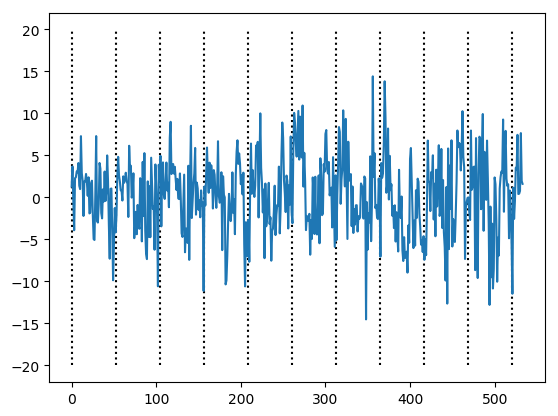

In [5]:
fig, ax = plt.subplots()
ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(df['Value'])
fig

Нельзя ничего сказать про сезонность ряда, глядя на график

Посмотрим на интегрированный временной ряд:

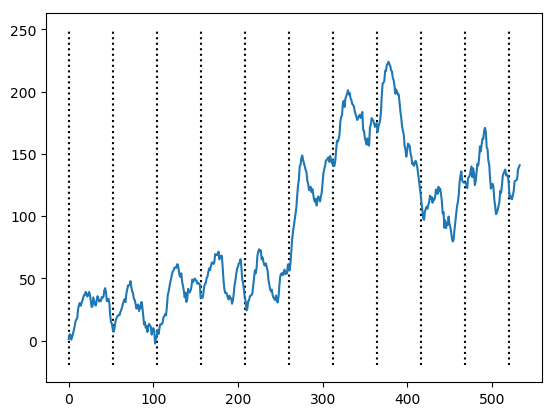

In [247]:
fig, ax = plt.subplots()
ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=250, color='black', linestyle=':')
ax.plot(df['Value'].cumsum())
fig

Здесь сезонность чувствуется намного более ярко выраженной

Также посмотрим на график автокорреляции

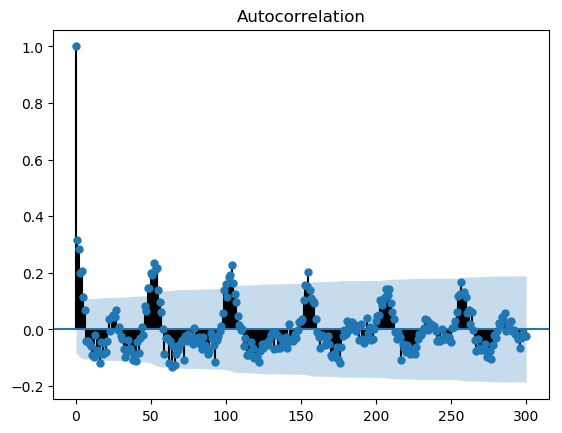

In [248]:
plot_acf(df['Value'], lags=300)

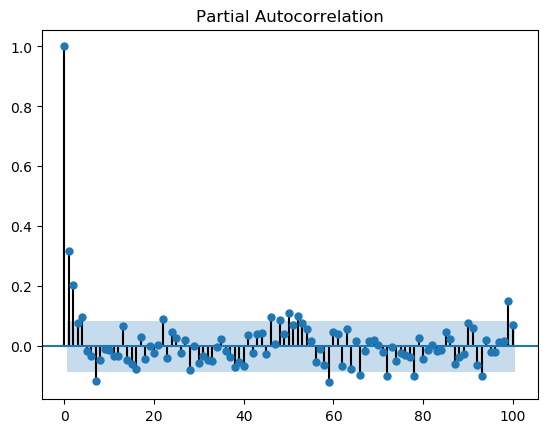

In [306]:
plot_pacf(df['Value'], lags=100)

Очевидна сезонность шириной 52 недели (1 год)

Посмотрим на графики автокорреляции для диффенцированного по сезонности ряду

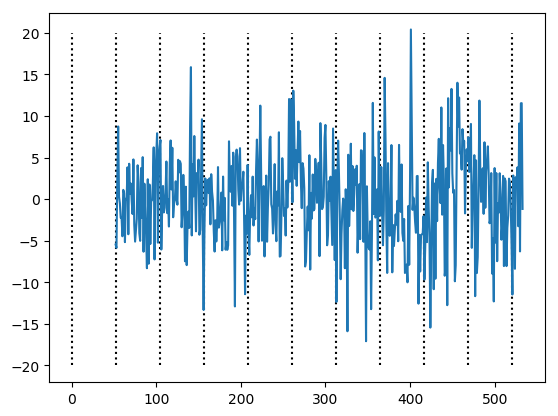

In [273]:
seasonal_diff = df['Value'].diff(52).dropna()

fig, ax = plt.subplots()
ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(seasonal_diff)
fig

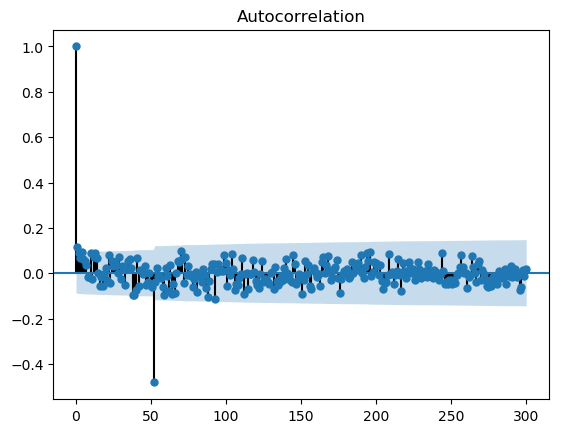

In [274]:
plot_acf(seasonal_diff, lags=300)

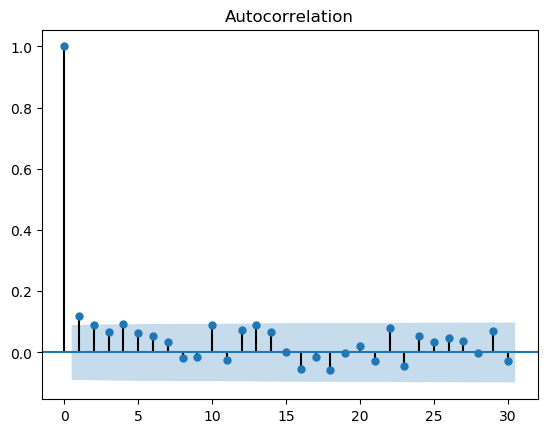

In [275]:
plot_acf(seasonal_diff, lags=30)

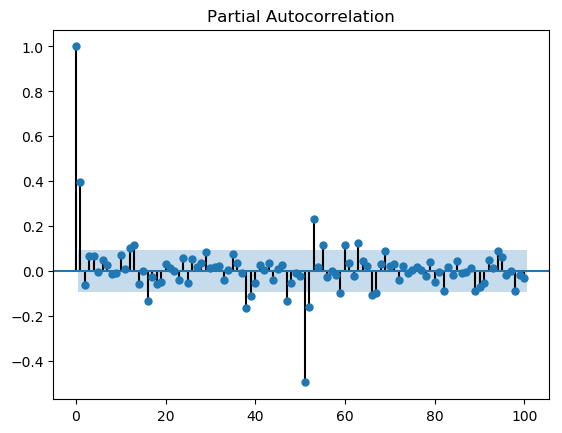

In [272]:
plot_pacf(seasonal_diff, method='ywmle', lags=100)

Попробуем взять простую смешанную модель с сезонным дифференцированием ARIMA(1,0,1)(0,1,0,52)

# ARIMA(1,0,1)(0,1,0,52)

In [307]:
model = ARIMA(df['Value'], order=(2,0,2), seasonal_order=(0,1,0,52))
model_res = model.fit()
model_res.summary()

C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  530
Model:             ARIMA(2, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1483.418
Date:                           Tue, 31 Mar 2020   AIC                           2976.836
Time:                                   07:12:12   BIC                           2997.684
Sample:                                        0   HQIC                          2985.033
                                           - 530                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3385     40.698      0.008      0.993     -79.429      80.106
ar.L2          0.4311     34.455      0.013      0.990     -67.099      67.962
ma.L1         -0.2463     40.685     -0.006      0.995     -79.987      79.495
ma.L2         -0.3853     30.701     -0.013      0.990     -60.558      59.787
sigma2        29.0423      1.732     16.772      0.000      25.649      32.436
===================================================================================
Ljung-Box (Q):                       49.79   Jarque-Bera (JB):                 7.12
Prob(Q):                              0.14   Prob(JB):                         0.03
Heteroskedasticity (H):               1.77   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

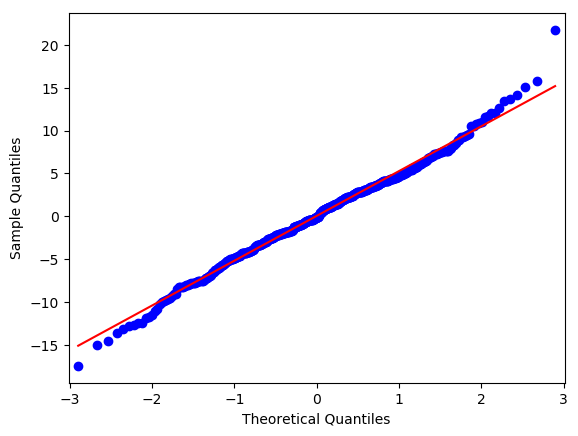

In [310]:
qqplot(model_res.resid, line='s')

Хвосты остатков выглядят тяжелыми

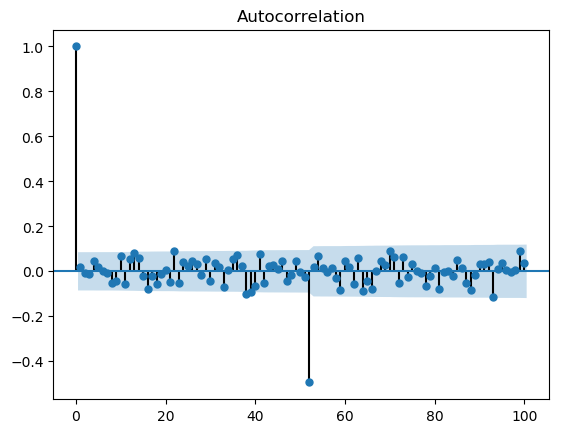

In [312]:
plot_acf(model_res.resid, lags=100)

Как видно, остатки с лагом 62 значительно скоррелированны

In [313]:
ljungbox_df = acorr_ljungbox(model_res.resid, return_df=True, model_df=2, lags=60)
ljungbox_df['Pr > 0.05'] = ljungbox_df['lb_pvalue'] > 0.05
ljungbox_df.dropna(inplace=True)
ljungbox_df

,lb_stat,lb_pvalue,Pr > 0.05
3,0.328604,5.664822e-01,True
4,1.362199,5.060602e-01,True
5,1.536807,6.738018e-01,True
6,1.536894,8.200868e-01,True
7,1.586430,9.028855e-01,True
8,2.935749,8.168667e-01,True
9,3.851062,7.967635e-01,True
10,6.258683,6.182803e-01,True
11,8.094715,5.246302e-01,True
12,9.770124,4.608874e-01,True


In [314]:
print(f'Is all lags pvalue > 0.05: {ljungbox_df["Pr > 0.05"].all()}')

Is all lags pvalue > 0.05: False


Также как видно по тесту Льинг-Бокса, остатки с лагом около 52 скоррелированны

# SARIMA(1,0,1)(0,1,1,52) 
В предыдущей модели остатки получилсь автокоррелированы при лагах около 52. Очевидно, что нужно применить модель с учетом сезонности

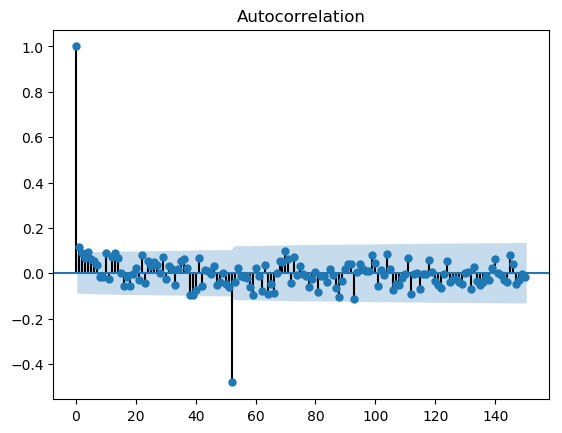

In [318]:
plot_acf(seasonal_diff, lags=150)

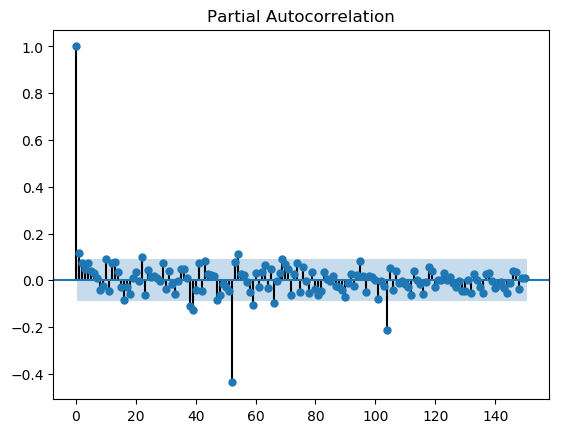

In [316]:
plot_pacf(seasonal_diff, method='ywmle', lags=150)

По этому дифференцированному ряду можно попробовать взять смешанную модель ARIMA(1, 0, 1) x SARIMA(0,1,1,52) 

In [319]:
# model = ARIMA(diff2, order=(2,0,1))
model = ARIMA(df['Value'], order=(1,0,1), seasonal_order=(0,1,1,52))
model_res = model.fit()
model_res.summary()

C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Value   No. Observations:                  530
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1384.222
Date:                          Tue, 31 Mar 2020   AIC                           2776.443
Time:                                  07:17:22   BIC                           2793.122
Sample:                                       0   HQIC                          2783.001
                                          - 530                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7837      0.114      6.900      0.000       0.561       1.006
ma.L1         -0.6616      0.136     -4.852      0.000      -0.929      -0.394
ma.S.L52      -0.8491      0.067    -12.629      0.000      -0.981      -0.717
sigma2        16.7571      1.169     14.336      0.000      14.466      19.048
===================================================================================
Ljung-Box (Q):                       26.73   Jarque-Bera (JB):                 5.94
Prob(Q):                              0.95   Prob(JB):                         0.05
Heteroskedasticity (H):               1.80   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC ощутимо меньше, чем у предыдущей модели.

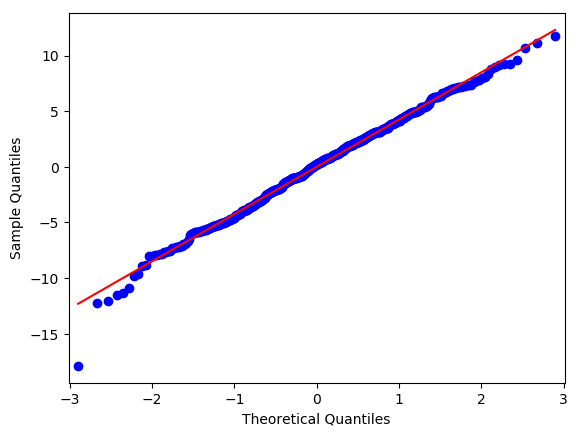

In [320]:
qqplot(model_res.resid, line='s')

Остатки выглядят нормальными, за исключением маленького хвоста слева

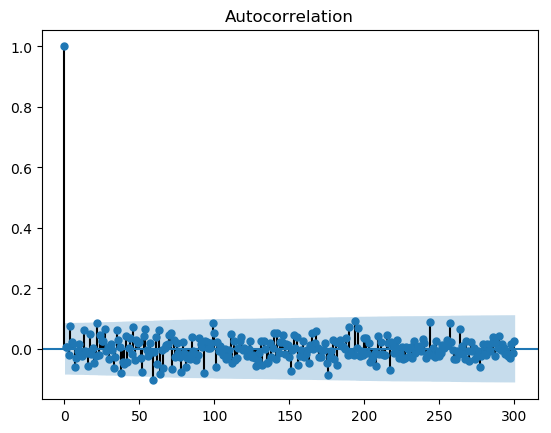

In [321]:
plot_acf(model_res.resid, lags=300)

При лаге 10 автокорреляция опасно на границе, но выглядит всё нормально

In [322]:
ljungbox_df = acorr_ljungbox(model_res.resid, return_df=True, model_df=3, period=52)
ljungbox_df['Pr > 0.05'] = ljungbox_df['lb_pvalue'] > 0.05
ljungbox_df.dropna(inplace=True)
ljungbox_df

,lb_stat,lb_pvalue,Pr > 0.05
4,3.175943,0.074730,True
5,3.428106,0.180134,True
6,3.551307,0.314168,True
7,5.579692,0.232813,True
8,6.088471,0.297705,True
...,...,...,...
100,99.785122,0.402898,True
101,102.144634,0.367136,True
102,102.518556,0.384221,True
103,102.560545,0.410368,True


In [323]:
print(f'Is all lags pvalue > 0.05: {ljungbox_df["Pr > 0.05"].all()}')

Is all lags pvalue > 0.05: True


По тесту Льинг-Бокса теперь видно, что для всех лагов до 40 остатки нескоррелированны, что намного лучше.

Очевидно, что эта модель предпочтительнее

# Прогнозирование

In [150]:
values_truncated = df['Value'][:-52]
truncated_part = df['Value'][-52:]

## ARIMA(1,0,1)(0,1,1,52)

In [354]:
model = ARIMA(values_truncated, order=(1,0,1), seasonal_order=(0,1,1,52))
model_res = model.fit()

prediction = model_res.predict(start=0, end=df['Value'].shape[0]+1)

C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


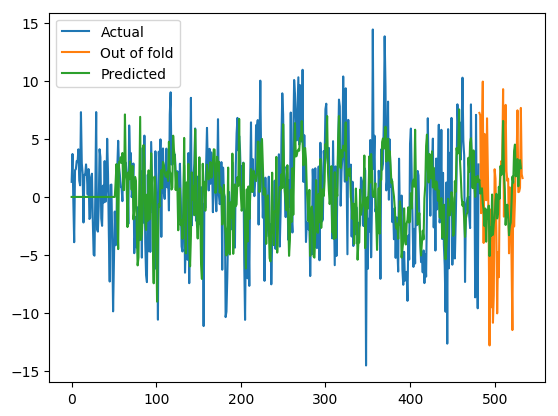

In [355]:
fig, ax = plt.subplots()
# ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(values_truncated, label='Actual')
ax.plot(truncated_part, label='Out of fold')
ax.plot(prediction, label='Predicted')
ax.legend()
fig

Не особенно понятно, поэтому я решил посмотреть как графики будут вести себя, если вычислить кумалятивную сумму настоящего ряда и предсказаний.

In [356]:
cumsum_values = df['Value'].cumsum()
values_truncated_cumsum = cumsum_values[:-52]
truncated_part_cumsum = cumsum_values[-52:]

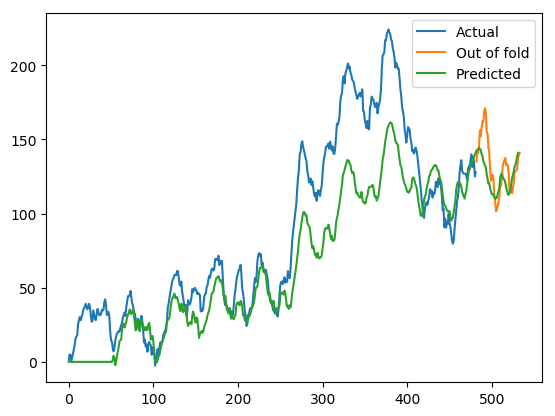

In [357]:
fig, ax = plt.subplots()
# ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(values_truncated_cumsum, label='Actual')
ax.plot(truncated_part_cumsum, label='Out of fold')
ax.plot(np.cumsum(prediction), label='Predicted')
ax.legend()
fig

Первый сезон модель выдяет практически нулевые значения, очевидно это из-за того, что у модели не было изначально данных о сезонной компоненте. Три сезоны посередине модель предсказывает не особо хорошо. Но убранный отрезок предсказывается достаточно близко

Вычилим "в лоб" суммарный модель ошибки на убранном отрезке:
$$\sum_{i=1}^{n}{|y_i-\hat{y}_i|}$$

In [358]:
print(f'Absolute error: {np.abs(truncated_part.values - prediction[-52:].values).sum():.2f}')

Absolute error: 208.30


Ради интереса, также подсчитаем модуль ошибки на кумулятивном графике. В этот раз, оба графика начинают отсчёт с одной и той же точки

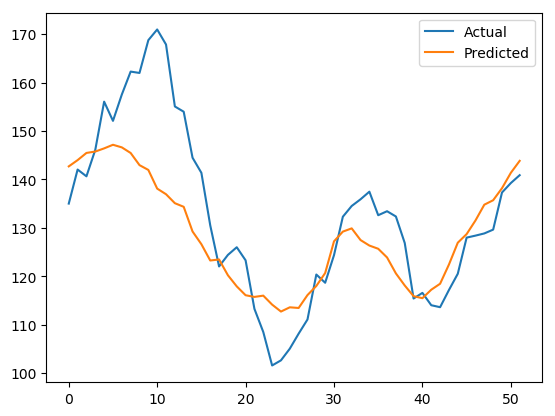

In [359]:
cumsum_predictions = np.cumsum(np.concatenate([[truncated_part_cumsum.values[-1]], prediction[-52:]]))[1:]

fig, ax = plt.subplots()
# ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(truncated_part_cumsum.values, label='Actual')
ax.plot(cumsum_predictions, label='Predicted')
ax.legend()
fig

In [360]:
print(f'Cumulative absolute error: {np.abs(truncated_part_cumsum.values - cumsum_predictions).sum():.2f}')

Cumulative absolute error: 430.51


## ARIMA (0,0,1)(0,1,0,52)

Интересно, как это будет выглядеть для несезонной ARIMA (0,0,1)(0,1,0,52)

C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


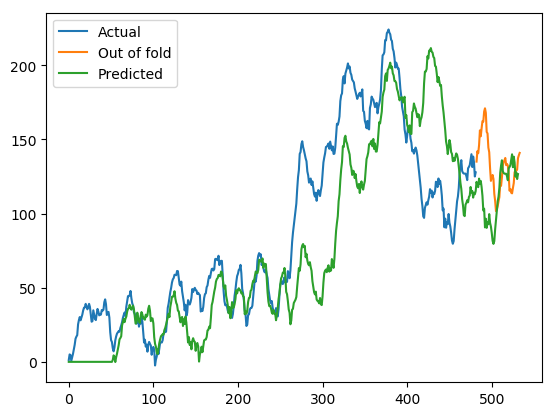

In [331]:
model = ARIMA(values_truncated, order=(0,0,1), seasonal_order=(0,1,0,52))
model_res = model.fit()
prediction = model_res.predict(start=0, end=df['Value'].shape[0]+1)
fig, ax = plt.subplots()
# ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(values_truncated_cumsum, label='Actual')
ax.plot(truncated_part_cumsum, label='Out of fold')
ax.plot(np.cumsum(prediction), label='Predicted')
ax.legend()
fig

Тут больше похоже, что модель просто повторяет предыдущий цикл

## Модель Хольта-Винтерса

C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


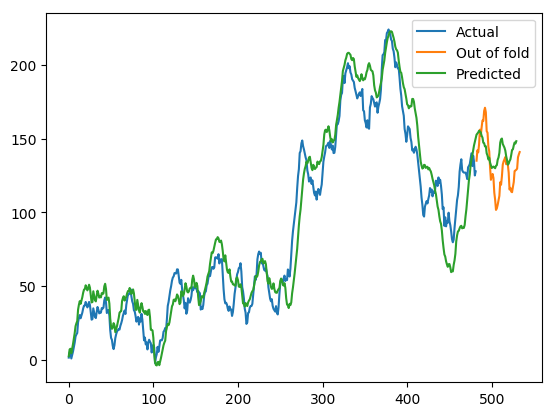

In [350]:
model = ExponentialSmoothing(values_truncated, seasonal='add', trend='add', seasonal_periods=52)
model_res = model.fit()

prediction = model_res.predict(start=0, end=df['Value'].shape[0]-1)

fig, ax = plt.subplots()
# ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(values_truncated_cumsum, label='Actual')
ax.plot(truncated_part_cumsum, label='Out of fold')
ax.plot(np.cumsum(prediction), label='Predicted')
ax.legend()
fig

In [351]:
print(f'Absolute error: {np.abs(truncated_part.values - prediction[-52:].values).sum():.2f}')

Absolute error: 187.45


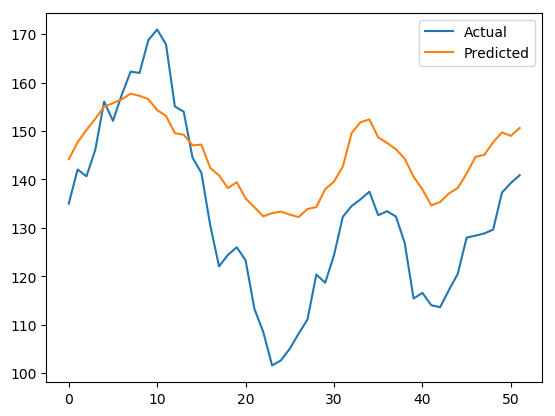

In [352]:
cumsum_predictions = np.cumsum(np.concatenate([[truncated_part_cumsum.values[-1]], prediction[-52:]]))[1:]

fig, ax = plt.subplots()
# ax.vlines(x=[52 * i for i in range(11)], ymin=-20, ymax=20, color='black', linestyle=':')
ax.plot(truncated_part_cumsum.values, label='Actual')
ax.plot(cumsum_predictions, label='Predicted')
ax.legend()
fig

In [353]:
print(f'Cumulative absolute error: {np.abs(truncated_part_cumsum.values - cumsum_predictions).sum():.2f}')

Cumulative absolute error: 748.41


Получается странно. Для сезонной ARIMA модели простая ошибка вышла больше, но кумулятивная меньше, если сравнивать с моделью Хольта-Винтерса